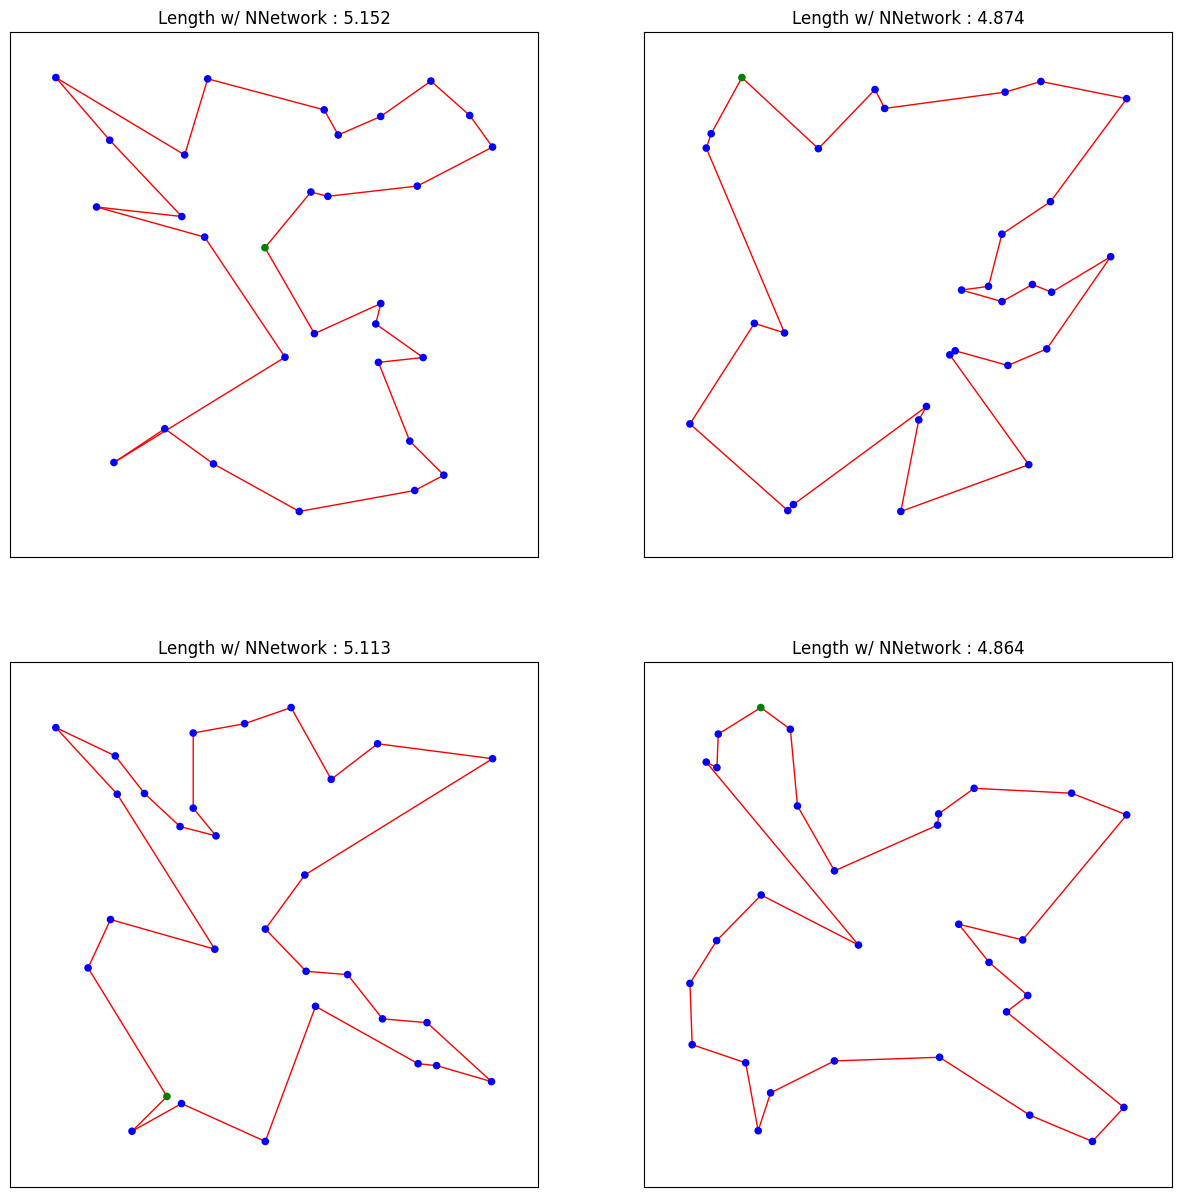

In [13]:
from model import plot_tsp, generate_data, seq2seq_generate_tour,MambaFull
import torch
coord_dim = 2
city_count = 30
test_size=2000
device = 'cuda'
test_data_loc=f'mamba/data/start_2/test_rand_{test_size}_{city_count}_{coord_dim}.pt'
#test_data = torch.load(test_data_loc).to(device)

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

checkpoint = torch.load('mamba/checkpoints/pointer_generalisation/5_20_10-07_00-28.pt')
args = checkpoint['args']
model_train = MambaFull(args.d_model, args.city_count, args.nb_layers, args.coord_dim, args.mlp_cls,args.B, args.reverse,args.reverse_start,args.mamba2,args.last_layer).to(device)
model_train.load_state_dict(checkpoint['model_baseline_state_dict'])
x = generate_data(device, 4, city_count, args.coord_dim)
tour, _ = seq2seq_generate_tour(device,model_train,x,deterministic=True,lastlayer=args.last_layer)
plot_tsp(x,tour)

In [ ]:
import torch
import torch.nn as nn
arr = torch.arange(0,4).reshape(1,1,4).float()
print(arr)
arr = nn.Softmax(dim=1)(arr)
arr

tensor([[[0., 1., 2., 3.]]])


tensor([[[1., 1., 1., 1.]]])